**1-Importation des bibliothèques** : Cette étape permet d'importer toutes les bibliothèques nécessaires pour le projet.


In [2]:
!pip install datasets scikit-fuzzy
!pip install twitter tweepy nltk scikit-learn ipython

import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
import skfuzzy as fuzz

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

**2-Chargement et Prétraitement des Tweets**:
Cette étape consiste à nettoyer les tweets pour supprimer les éléments inutiles, comme :
- Les hashtags (#),
- Les mentions (@nom_utilisateur),
- Les liens URL.

Cela permet de travailler uniquement avec le texte utile et d'améliorer l'analyse par la suite.


In [3]:
def load_and_preprocess_dataset():
    dataset = load_dataset("cardiffnlp/tweet_eval", "emoji")
    tweets = [example['text'] for example in dataset['train'].select(range(1000))]
    return tweets

def preprocess_tweet(tweet):
    tweet = re.sub(r'http\S+', '', tweet)
    tweet = re.sub(r'@\w+', '', tweet)
    tweet = re.sub(r'#', '', tweet)
    tweet = re.sub(r'\W', ' ', tweet)
    tweet = tweet.lower()
    return tweet

def process_tweet(tweet):
    tokens = word_tokenize(tweet)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

def preprocess_and_process_tweets(tweets):
    preprocessed = [preprocess_tweet(tweet) for tweet in tweets]
    processed = [process_tweet(tweet) for tweet in preprocessed]
    return processed

**3-Vectorisation et Réduction de Dimension** :
Pour analyser les tweets, on les transforme en nombres en utilisant la méthode TF-IDF.
- TF-IDF aide à donner une importance aux mots rares dans le texte et à ignorer les mots trop fréquents.
- Cela permet de mieux comparer les tweets entre eux.

Ensuite, je utilise TruncatedSVD pour réduire la dimensionnalité des vecteurs, ce qui permet une meilleure visualisation et une optimisation des performances des algorithmes de clustering.


In [4]:
def vectorize_and_reduce(tweets):
    vectorizer = TfidfVectorizer(max_features=5000, max_df=0.8, min_df=5)
    X = vectorizer.fit_transform(tweets).toarray()
    svd = TruncatedSVD(n_components=50, random_state=0)
    X_reduced = svd.fit_transform(X)
    return X_reduced

**4-Clustering avec K-Means** : K-Means est un algorithme qui regroupe les tweets similaires en groupes (ou clusters).
- Chaque groupe contient des tweets proches en termes de contenu.
- On teste plusieurs nombres de groupes (valeurs de k comme 5, 10, 15) pour voir laquelle fonctionne le mieux.

In [5]:
def cluster_tweets_kmeans(X, k):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10).fit(X)
    return kmeans.labels_

def execute_clustering_kmeans(X, k_range):
    k_results = {}
    for k in k_range:
        labels = cluster_tweets_kmeans(X, k)
        k_results[k] = labels
        print(f"K-Means terminé pour k = {k}")
    return k_results

**5-Clustering avec Fuzzy C-Means** : Cet algorithme permet à un tweet d'appartenir à plusieurs groupes avec des degrés d'appartenance (exemple : 70% dans un groupe et 30% dans un autre).
- Cela aide à mieux gérer les tweets qui pourraient être similaires à plusieurs groupes en même temps.

In [6]:
def cluster_tweets_fuzzy_cmeans(X, k):
    cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(X.T, c=k, m=2, error=0.005, maxiter=1000)
    labels = np.argmax(u, axis=0)
    return labels

def execute_clustering_fuzzy_cmeans(X, k_range):
    fuzzy_results = {}
    for k in k_range:
        labels = cluster_tweets_fuzzy_cmeans(X, k)
        fuzzy_results[k] = labels
        print(f"Fuzzy C-Means terminé pour k = {k}")
    return fuzzy_results

**5-Distance de Jaccard** :
Pour mesurer si deux tweets sont similaires, on utilise la distance de Jaccard.
- Si la distance est proche de 0, les tweets sont très similaires.
- Si la distance est proche de 1, les tweets sont très différent


In [7]:
def jaccard_distance(tweet1, tweet2):
    set1, set2 = set(tweet1.split()), set(tweet2.split())
    return 1 - len(set1 & set2) / len(set1 | set2)

**7-Sélection des Tweets Représentatifs** : Cette fonction permet de choisir un tweet représentatif pour chaque groupe (cluster) de tweets similaires. Son but est de Sélectionner un tweet qui représente le mieux chaque groupe de tweets similaires.
- Cela permet de réduire l'information en présentant un seul tweet par groupe au lieu de tous les tweets, ce qui rend la lecture plus facile pour l'utilisateur.


In [8]:
def select_representative_tweets(tweets, labels):
    representative_tweets = []
    for label in set(labels):
        class_tweets = [tweets[i] for i in range(len(tweets)) if labels[i] == label]
        centroid = min(class_tweets, key=lambda tweet: sum(jaccard_distance(tweet, other) for other in class_tweets))
        representative_tweets.append(centroid)
    return representative_tweets

**8-Visualisation des Clusters** : Cette fonction permet de visualiser les groupes de tweets (clusters) sur un graphique.

In [9]:
def plot_clusters(X, labels, title):
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
    plt.colorbar()
    plt.title(title)
    plt.show()

**9-Pipeline Principal et Visualisation** : Ce pipeline exécute toutes les étapes du traitement des tweets et de la visualisation des résultats.
- **Clustering** : Deux méthodes de clustering sont utilisées :
     - K-Means            ""k_range = range(2, 31)""
     - Fuzzy C-Means      ""k_range = range(2, 31)""
     
Les résultats des clusters sont affichés sur des graphiques 2D et les tweets représentatifs pour chaque méthode de clustering sont imprimés.
- Ce pipeline regroupe toutes les étapes du projet pour faciliter l'exécution et la visualisation des résultats.

Après avoir exécuté ce pipeline, on obtenir des clusters visualisés et les tweets représentatifs de chaque cluster pour les deux méthodes de clustering (K-Means et Fuzzy C-Means).


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.61M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/3.05M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/282k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/45000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5000 [00:00<?, ? examples/s]

K-Means terminé pour k = 2
K-Means terminé pour k = 3
K-Means terminé pour k = 4
K-Means terminé pour k = 5
K-Means terminé pour k = 6
K-Means terminé pour k = 7
K-Means terminé pour k = 8
K-Means terminé pour k = 9
K-Means terminé pour k = 10
K-Means terminé pour k = 11
K-Means terminé pour k = 12
K-Means terminé pour k = 13
K-Means terminé pour k = 14
K-Means terminé pour k = 15
K-Means terminé pour k = 16
K-Means terminé pour k = 17
K-Means terminé pour k = 18
K-Means terminé pour k = 19
K-Means terminé pour k = 20
K-Means terminé pour k = 21
K-Means terminé pour k = 22
K-Means terminé pour k = 23
K-Means terminé pour k = 24
K-Means terminé pour k = 25
K-Means terminé pour k = 26
K-Means terminé pour k = 27
K-Means terminé pour k = 28
K-Means terminé pour k = 29
K-Means terminé pour k = 30
Fuzzy C-Means terminé pour k = 2
Fuzzy C-Means terminé pour k = 3
Fuzzy C-Means terminé pour k = 4
Fuzzy C-Means terminé pour k = 5
Fuzzy C-Means terminé pour k = 6
Fuzzy C-Means terminé pour k = 

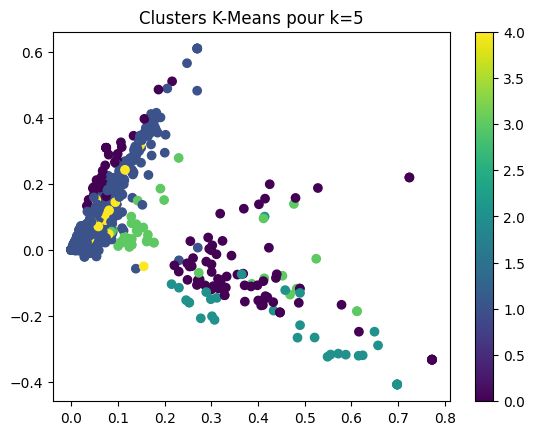

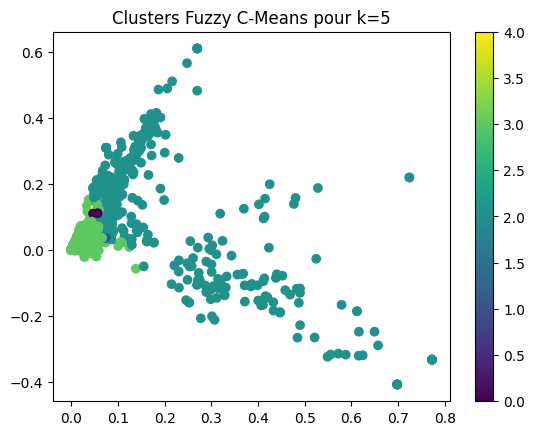

Tweets représentatifs (K-Means) :  ['@ Pismo Beach, California', 'Nine in the afternoon ️ @user @ Irvine Meadows Amphitheatre', '️ ️ ️ @ Los Angeles, California', '#sandiego @ San Diego, California', 'Christmas is my favorite time of year. #lovethesetwotodeath…']
Tweets représentatifs (Fuzzy C-Means) :  ['Sunday vibes are the best ️ @ Victory Missionary Baptist Church', 'Sheenie @ American Junkie Newport Beach', '️ ️ ️ @ Los Angeles, California', '@user ️ @ Fox Theater Pomona', 'Missed my best friend @ Spokane, Washington']


In [10]:
!pip install nltk
import nltk
nltk.download('punkt_tab')
def main_pipeline():
    tweets = load_and_preprocess_dataset()
    processed_tweets = preprocess_and_process_tweets(tweets)

    X = vectorize_and_reduce(processed_tweets)


    k_range = range(2, 31)
    kmeans_results = execute_clustering_kmeans(X, k_range)
    fuzzy_results = execute_clustering_fuzzy_cmeans(X, k_range)

    kmeans_labels = kmeans_results[5]
    fuzzy_labels = fuzzy_results[5]
    representative_kmeans = select_representative_tweets(tweets, kmeans_labels)
    representative_fuzzy = select_representative_tweets(tweets, fuzzy_labels)

    plot_clusters(X, kmeans_labels, "Clusters K-Means pour k=5")
    plot_clusters(X, fuzzy_labels, "Clusters Fuzzy C-Means pour k=5")

    print("Tweets représentatifs (K-Means) : ", representative_kmeans)
    print("Tweets représentatifs (Fuzzy C-Means) : ", representative_fuzzy)

main_pipeline()

**10- Téléchargement du fichier requirements.txt**

In [13]:
from google.colab import files

output_file = "requirements.txt"
files.download(output_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>